In [1]:
## Imports Libraries and Packages
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
## Seeding 
seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
# convert image to tensor 
def load_image(img_path, show=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    img_tensor = img_to_array(img)                          

    return img_tensor

In [4]:
x = []
y = []

def get_image(path):
    data =[]
    for subdir, dirs, files in os.walk(path):
        for f in files:
            path = os.path.join(subdir, f)
            img = load_image(path)     
            img = img/255.0
            data.append(img)
    return data


x = get_image(r'C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\competition_data\competition_data\train\images')
y = get_image(r'C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\competition_data\competition_data\train\masks')

x = np.asarray(x)
y = np.asarray(y)

In [5]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=42)
print(x.shape)
print(y.shape)

(4000, 128, 128, 1)
(4000, 128, 128, 1)


Text(0.5, 1.0, 'Salt')

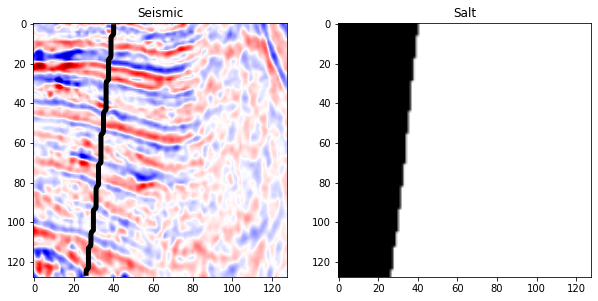

In [6]:
# Visualize any random image and their mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if it's a salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [7]:
# UNet model for classification
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)     
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)     
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4)     
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(input_img, outputs)
    return model

In [8]:
input_img = Input((128, 128, 1), name='img')
model = UNet(input_img)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
#Using EarlyStopping to stop the training if the algorithm is not converging, 
#ReduceLROnPlateau to change the learning rate in runtime if the algorithm is not converging,
#ModelCheckpoint to save the model time to time whenever there is a imporvement
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(r'C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\model_tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
# train the network
model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.4742 - acc: 0.8007
Epoch 00001: val_loss improved from inf to 1.75239, saving model to C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\model_tgs.h5
3600/3600 [==============================] - 542s 151ms/sample - loss: 0.4747 - acc: 0.8005 - val_loss: 1.7524 - val_acc: 0.7603
Epoch 2/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.3199 - acc: 0.8842
Epoch 00002: val_loss improved from 1.75239 to 0.52817, saving model to C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\model_tgs.h5
3600/3600 [==============================] - 578s 160ms/sample - loss: 0.3199 - acc: 0.8841 - val_loss: 0.5282 - val_acc: 0.8522
Epoch 3/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.2853 - acc: 0.8887
Epoch 00003: val_loss improved from 0.52817 to 0.42038, saving model to C:\Users\rnaman\Desktop\kaggle p

3584/3600 [============================>.] - ETA: 2s - loss: 0.0800 - acc: 0.9664
Epoch 00026: val_loss did not improve from 0.13729
3600/3600 [==============================] - 538s 149ms/sample - loss: 0.0801 - acc: 0.9664 - val_loss: 0.1478 - val_acc: 0.9437
Epoch 27/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.0804 - acc: 0.9663
Epoch 00027: val_loss did not improve from 0.13729
3600/3600 [==============================] - 527s 146ms/sample - loss: 0.0804 - acc: 0.9663 - val_loss: 0.1475 - val_acc: 0.9431
Epoch 28/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.0789 - acc: 0.9668
Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00028: val_loss did not improve from 0.13729
3600/3600 [==============================] - 529s 147ms/sample - loss: 0.0787 - acc: 0.9669 - val_loss: 0.1471 - val_acc: 0.9442
Epoch 29/50
3584/3600 [============================>.] - ETA: 2s - loss: 0.0766 - acc: 0.9674
Epoch 00029: v

In [11]:
model.save(r'C:\Users\rnaman\Desktop\kaggle project\tgs-salt-identification-challenge\model_tgs.h5')

In [12]:
# Predict on train and val
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

3600/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [13]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [14]:
def plot_sample(X, y, preds, binary_preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

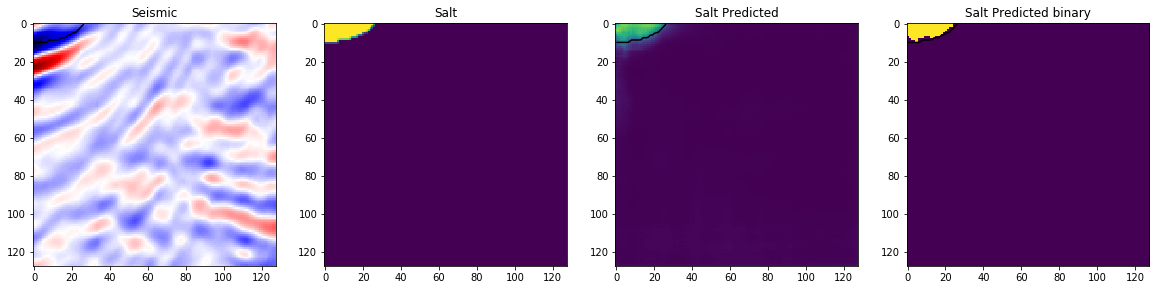

In [21]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

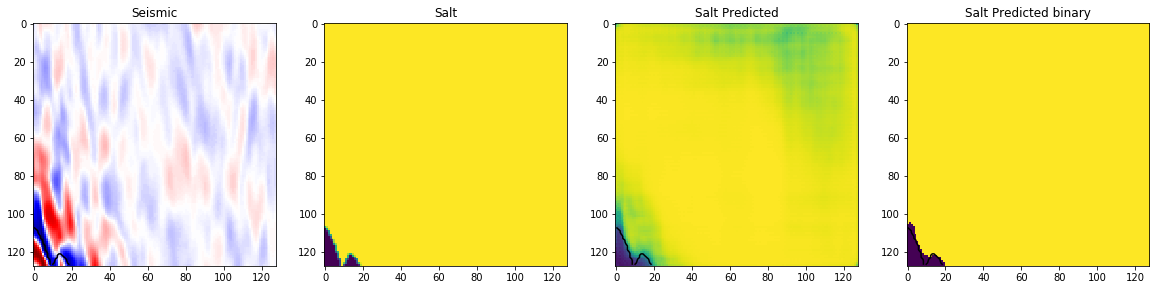

In [24]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

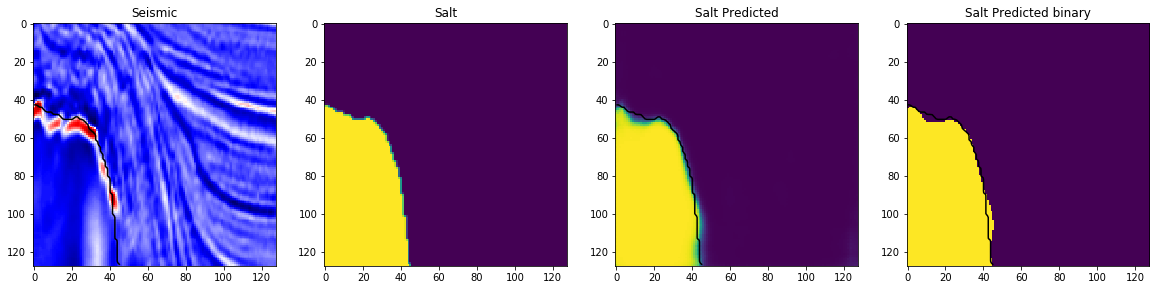

In [26]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

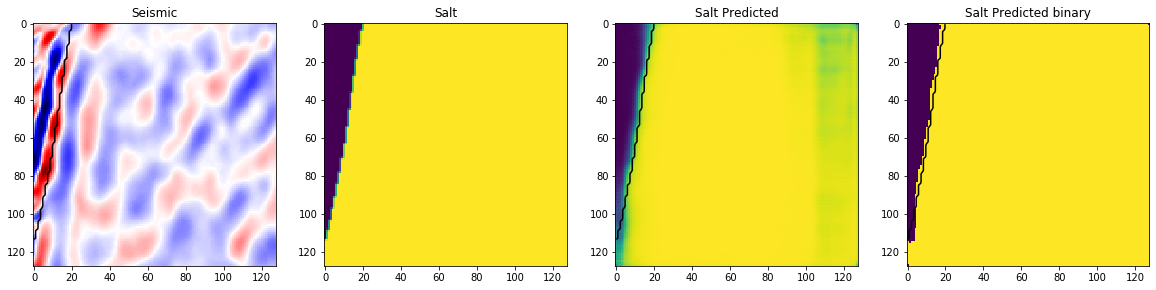

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)